In [6]:
!pip install -q sentence-transformers hdbscan umap-learn unidecode


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 24.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.8 MB/s eta 0:00:00:00:0100:01


In [7]:
import pandas as pd


products = pd.read_csv("/kaggle/input/instacart-market-basket-analysis/products.csv")
aisles = pd.read_csv("/kaggle/input/instacart-market-basket-analysis/aisles.csv")
departments = pd.read_csv("/kaggle/input/instacart-market-basket-analysis/departments.csv")

In [8]:
# Merge metadata
prod = products.merge(aisles, on="aisle_id").merge(departments, on="department_id")
prod = prod[["product_id","product_name","aisle","department"]]
prod.head()

,product_id,product_name,aisle,department
0,1,Chocolate Sandwich Cookies,cookies cakes,snacks
1,2,All-Seasons Salt,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,frozen meals,frozen
4,5,Green Chile Anytime Sauce,marinades meat preparation,pantry


In [9]:
import re
from unidecode import unidecode

# Patterns for sizes, units, and noise words
UNITS = r"(oz|ounce|ounces|lb|pound|g|kg|ml|l|liter|litre|pack|ct|count)"
SIZES = rf"\b\d+(\.\d+)?\s*({UNITS})\b|\b(pack\s*of\s*\d+)\b|\b\d+\b"
NOISE = r"\b(organic|gluten[- ]?free|non[- ]?gmo|fresh|new|brand|original)\b"
PUNCT = r"[^\w\s]"

def clean_name(s: str) -> str:
    s = unidecode(str(s)).lower().strip()
    s = re.sub(SIZES, " ", s)
    s = re.sub(PUNCT, " ", s)
    s = re.sub(NOISE, " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

prod["name_clean"] = prod["product_name"].apply(clean_name)
prod.sample(10)[["product_name","name_clean","aisle","department"]]


,product_name,name_clean,aisle,department
35350,"Couscous, Organic, Brown Rice, Original",couscous brown rice,instant foods,dry goods pasta
24660,Garlic Aioli,garlic aioli,condiments,pantry
34590,Pure Ground,pure ground,spices seasonings,pantry
11898,Drumstick Crunch Dipped Vanilla Fudge/Vanilla ...,drumstick crunch dipped vanilla fudge vanilla ...,ice cream ice,frozen
3860,Fresh Mushroom Pasta Sauce,mushroom pasta sauce,pasta sauce,dry goods pasta
43331,Kickstart Energizing Fruit Punch,kickstart energizing fruit punch,juice nectars,beverages
26739,Sparklers Tangerine Mango,sparklers tangerine mango,water seltzer sparkling water,beverages
8245,Total Clean Mint Toothpaste,total clean mint toothpaste,oral hygiene,personal care
30153,Lemon Cupcakes,lemon cupcakes,bakery desserts,bakery
46272,Regular Strength Pills Stimulant Laxative,regular strength pills stimulant laxative,digestion,personal care


In [10]:
# Frequency count
freq = prod["name_clean"].value_counts().rename("freq").reset_index()
freq = freq.rename(columns={"index":"name_clean"})

# Merge back to get sample product_id and original name
canon = freq.merge(prod, on="name_clean", how="left").drop_duplicates("name_clean")
canon = canon[["name_clean","product_id","product_name","freq","aisle","department"]]
canon.head()


,name_clean,product_id,product_name,freq,aisle,department
0,reduced fat milk,1940,Organic 2% Reduced Fat Milk,11,milk,dairy eggs
11,apple juice,14957,Organic 100% Apple Juice,9,juice nectars,beverages
20,lowfat milk,6533,1% Lowfat Organic Milk,8,milk,dairy eggs
28,vitamin d3 iu,4388,Vitamin D3 2000 IU,7,vitamins supplements,personal care
35,dark chocolate bar,3083,85% Dark Chocolate Bar,7,candy chocolate,snacks


In [11]:
from sentence_transformers import SentenceTransformer
import numpy as np

model = SentenceTransformer("all-MiniLM-L6-v2")  # fast and effective
names = canon["name_clean"].tolist()
X = model.encode(names, batch_size=256, convert_to_numpy=True, normalize_embeddings=True)


2025-09-03 04:32:15.597375: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756873935.929922      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756873936.026873      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/184 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


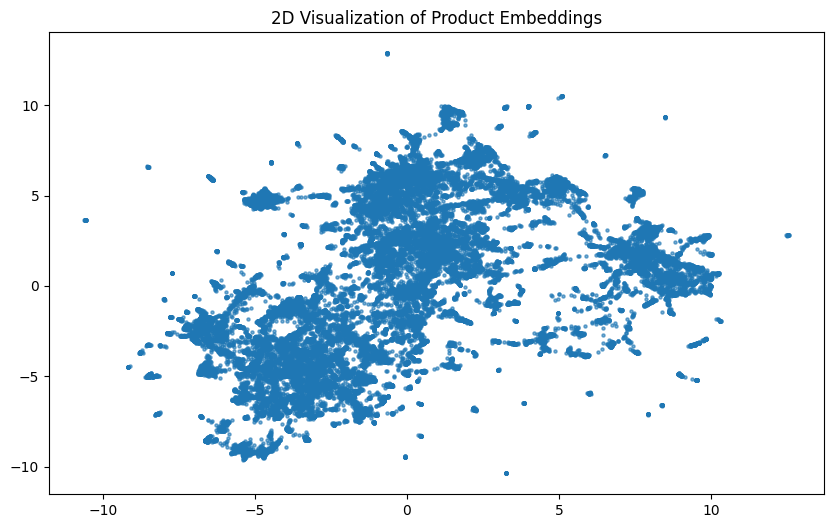

In [12]:
import umap
import matplotlib.pyplot as plt

X2 = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="cosine", random_state=42).fit_transform(X)
plt.figure(figsize=(10,6))
plt.scatter(X2[:,0], X2[:,1], s=5, alpha=0.6)
plt.title("2D Visualization of Product Embeddings")
plt.show()


In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50, random_state=42)
X_reduced = pca.fit_transform(X)


In [14]:
import hdbscan

# HDBSCAN clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=20, min_samples=10, metric="euclidean")
labels = clusterer.fit_predict(X_reduced)
canon["cluster_hdb"] = labels
canon["cluster_hdb"].value_counts().head(10)


cluster_hdb
-1      38328
 118      584
 43       408
 56       316
 39       275
 122      251
 85       219
 58       191
 95       179
 36       170
Name: count, dtype: int64

In [15]:
import numpy as np

# Unique labels (excluding noise, which is -1)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

print("Number of clusters found:", n_clusters)


Number of clusters found: 131


In [16]:
from sklearn.metrics import silhouette_score

# Silhouette score (exclude noise points labeled -1)
mask = canon["cluster_hdb"] != -1
sil = silhouette_score(X_reduced[mask], canon.loc[mask,"cluster_hdb"]) if mask.any() else float("nan")
print("Silhouette score:", sil)

# Purity vs aisle
def purity(df, cluster_col, meta_col):
    groups = df[df[cluster_col] != -1].groupby(cluster_col)[meta_col].apply(lambda s: s.value_counts().max()/len(s))
    return groups.mean()

purity_aisle = purity(canon, "cluster_hdb", "aisle")
purity_dept = purity(canon, "cluster_hdb", "department")
print("Purity - Aisle:", purity_aisle)
print("Purity - Department:", purity_dept)


Silhouette score: 0.24609426
Purity - Aisle: 0.7599394751324037
Purity - Department: 0.8369583273712385


In [17]:
def exemplars(df, label_col, n=10):
    ex = []
    for cid, g in df[df[label_col]!=-1].groupby(label_col):
        top = g.sort_values("freq", ascending=False).head(n)
        ex.append((cid, top["name_clean"].tolist()))
    return ex

examples = exemplars(canon, "cluster_hdb", n=8)
for cid, items in examples[:15]:
    print(f"\nCluster {cid}:")
    for it in items: print(" -", it)



Cluster 0:
 - soft white w light bulb
 - general purpose light bulbs soft white 25w
 - clear watt appliance light bulb
 - light bulb soft white 150w
 - soft white watts general purpose light bulb
 - indoor floodlight soft white 65w light bulb
 - watt reveal way light bulb
 - soft white watts way light bulbs

Cluster 1:
 - imitation crab leg style
 - crab cakes handmade
 - crab delights imitation flake style crab meat
 - crab meat backfin lump
 - premium crab meat
 - imitation crab sticks
 - flake style imitation crab
 - imitation crabmeat

Cluster 2:
 - large grade aa eggs
 - grade a large brown eggs
 - egg whites
 - grade a large eggs
 - egg nog
 - brown eggs
 - liquid egg whites
 - extra large eggs

Cluster 3:
 - living drip catch cuff large gloves
 - large green gloves
 - handsaver flex strong small gloves
 - latex gloves
 - medium household gloves
 - medium latex gloves
 - bliss premium latex free gloves
 - medium premium latex free gloves

Cluster 4:
 - premium lubricant condoms 

In [18]:
canon["cluster_hdb"] = labels


In [19]:
# Group by cluster
cluster_groups = canon.groupby("cluster_hdb")

# Display first 5 clusters with product names and aisles
for cluster_id, group in cluster_groups:
    if cluster_id == -1:  # Skip noise points
        continue
    print(f"\nCluster {cluster_id} (size={len(group)}):")
    for _, row in group.iterrows():
        print(f" - {row['name_clean']} ({row['aisle']})")
    # Stop after first 5 clusters
    if cluster_id >= 4:
        break



Cluster 0 (size=32):
 - soft white w light bulb (more household)
 - general purpose light bulbs soft white 25w (more household)
 - light bulbs soft white 40w (more household)
 - halogen soft white watt light bulbs (more household)
 - light bulb a21 way (more household)
 - watt energy smart soft white light bulb (more household)
 - soft white light bulbs w (more household)
 - bulb crystal clear medium base watt (more household)
 - soft white watts halogen bulb (more household)
 - soft white halogen watt double life light bulb (more household)
 - w indoor light bulbs (more household)
 - reading way indoor watts light bulb (more household)
 - soft white watts halogen bulbs (more household)
 - nightlight specialty watt light bulbs (more household)
 - reveal watt halogen bulb (more household)
 - crystal clear decorative watt a medium base ceiling fan light bulb (other)
 - energy efficient soft white watt general purpose halogen bulbs (more household)
 - watt decorative soft white light bul

In [20]:
def cluster_purity(df, cluster_col="cluster_hdb", aisle_col="aisle"):
    purities = []
    for cluster_id, group in df[df[cluster_col]!=-1].groupby(cluster_col):
        top_count = group[aisle_col].value_counts().max()
        purities.append(top_count / len(group))
    return sum(purities)/len(purities)

purity_score = cluster_purity(canon)
print("Average cluster purity (aisle):", purity_score)


Average cluster purity (aisle): 0.7599394751324036


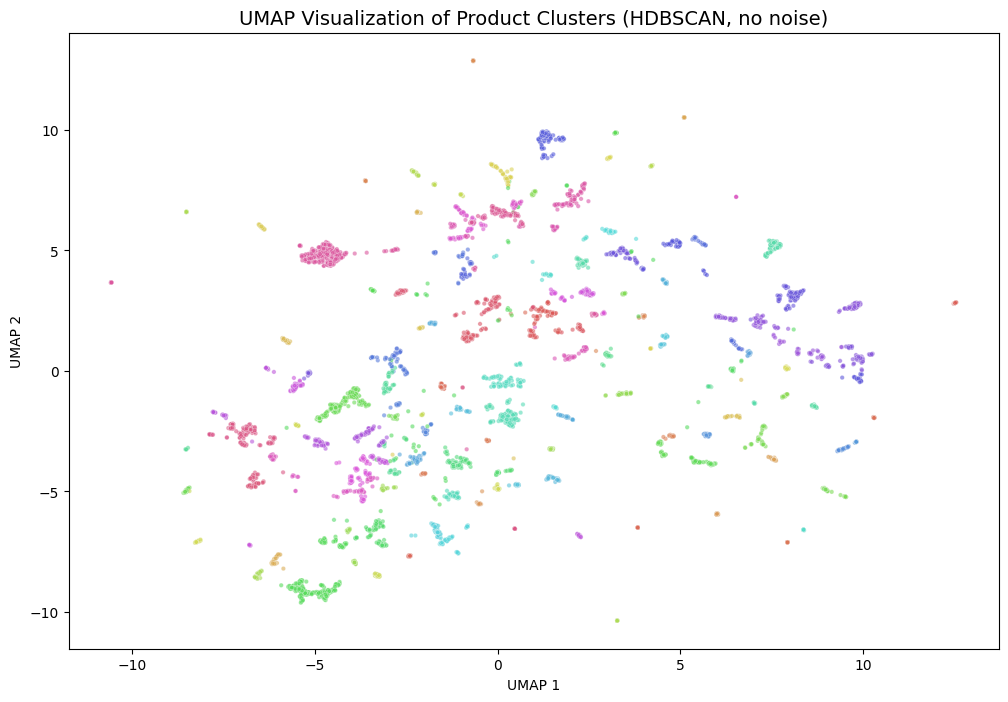

In [31]:
import seaborn as sns

# Keep only non-noise points
mask = labels != -1
X2_filtered = X2[mask]
labels_filtered = labels[mask]

plt.figure(figsize=(12, 8))
palette = sns.color_palette("hls", len(set(labels_filtered)))

sns.scatterplot(
    x=X2_filtered[:, 0],
    y=X2_filtered[:, 1],
    hue=labels_filtered,
    palette=palette,
    s=10,
    alpha=0.6,
    legend=False
)

plt.title("UMAP Visualization of Product Clusters (HDBSCAN, no noise)", fontsize=14)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()


In [101]:
# Skip noise (-1)
cluster_products = canon[canon["cluster_hdb"] != -1].groupby("cluster_hdb")["product_name"].apply(list)

# Take a sample per cluster (otherwise too big)
cluster_samples = cluster_products.apply(lambda x: x[:5])  # first 10 product names per cluster


In [102]:
cluster_samples

cluster_hdb
0      [Soft White 150 W Light Bulb, General Purpose ...
1      [Imitation Crab, Leg Style, Crab Cakes Handmad...
2      [Large Grade AA Eggs, Egg Whites, Grade A Larg...
3      [Living Drip Catch Cuff Large Gloves, Large Gr...
4      [Premium Lubricant Condoms ENZ, Magnum Thin Lu...
                             ...                        
126    [Organic Cookies 'n Cream Ice Cream, Original ...
127    [Organic Gluten-Free Chocolate Chip Cookies, G...
128    [Unsweetened Almond Milk, Unsweetened Almond B...
129    [Chocolate Chip Protein Bar, Gluten Free Peanu...
130    [85% Dark Chocolate Bar, 70% Dark Chocolate, D...
Name: product_name, Length: 131, dtype: object

### rule-based label extraction

In [91]:
# Group products by cluster
cluster_groups = canon[canon["cluster_hdb"] != -1].groupby("cluster_hdb")

# Extract product names per cluster
cluster_samples = {cid: list(group["name_clean"]) for cid, group in cluster_groups}


In [92]:
from collections import Counter

def cluster_label_rule(cluster_items, top_n=1):
    """
    Assign a short human-readable label to a cluster.
    1. Lowercase everything
    2. Remove common noise words
    3. Pick the most frequent meaningful word(s)
    """
    stopwords = {"organic","fresh","extra","original","light","firm","soft","premium","whole","low","sodium","ct"}
    
    words = " ".join(cluster_items).lower().split()
    words = [w for w in words if w not in stopwords]
    
    if not words:
        return "misc"
    
    most_common = Counter(words).most_common(top_n)
    return " ".join([w for w, _ in most_common])


In [93]:
all_labels = {cid: cluster_label_rule(items) for cid, items in cluster_samples.items()}

# Map back to canon dataframe
canon["cluster_label"] = canon["cluster_hdb"].map(all_labels)


In [95]:
# Print first 10 clusters with sample products and labels
for i, (cid, items) in enumerate(cluster_samples.items()):
    if i >= 10:  # only first 10 clusters
        break
    label = all_labels[cid]
    sample_items = items[:5]  # show first 5 products
    print(f"\nCluster {cid} → {label}")
    for item in sample_items:
        print(f" - {item}")



Cluster 0 → white
 - soft white w light bulb
 - general purpose light bulbs soft white 25w
 - light bulbs soft white 40w
 - halogen soft white watt light bulbs
 - light bulb a21 way

Cluster 1 → crab
 - imitation crab leg style
 - crab cakes handmade
 - white crab meat
 - imitation crab flakes
 - fancy crab meat with leg meat

Cluster 2 → eggs
 - large grade aa eggs
 - egg whites
 - grade a large brown eggs
 - cage free brown eggs large grade a
 - eggnog

Cluster 3 → gloves
 - living drip catch cuff large gloves
 - large green gloves
 - large household gloves
 - latex free ultimate household gloves small
 - latex free disposable vinly gloves

Cluster 4 → condoms
 - premium lubricant condoms enz
 - magnum thin lubricated condoms
 - her pleasure ecstasy ultrasmooth lubricant latex condoms
 - double ecstasy lubricated condoms
 - ultra thin condoms

Cluster 5 → oregano
 - rosemary
 - oregano
 - oregano leaf
 - rosemary crostini
 - wild oregano oil

Cluster 6 → plates
 - paper plates
 - sq

### llm labeling

In [96]:
!pip install transformers sentencepiece --quiet

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [97]:
model_name = "google/flan-t5-small"  # free & lightweight
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Create a pipeline for text generation
generator = pipeline("text2text-generation", model=model, tokenizer=tokenizer)


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Device set to use cpu


In [141]:
def label_cluster_llm_strict(cluster_id, cluster_items, max_items=15):
    items_sample = cluster_items[:max_items]
    
    prompt = f"""
You are an expert in grocery product categorization.
I will give you a list of similar product names in a cluster.
Output **exactly ONE concise label (1-3 words)** that describes all items.
Do NOT repeat product names. Do NOT add commas or extra words. Only one word length name.

Cluster {cluster_id} items:
{', '.join(items_sample)}

Label:
"""
    result = generator(prompt, max_new_tokens=5)[0]['generated_text'].strip()
    return result


In [143]:
# for cid, items in cluster_samples.items():
#     label = label_cluster_llm_strict(cid, items)
#     print(f"Cluster {cid} → {label}")
 
